# Where a Senator's Funding Comes From
##### Isaac J. Rabbani, EliteDataScience Capstone Project

## Introduction

In this short write-up, I will explore data on donations to Senator Jack Reed (D-RI). The dataset comes from publicly available FEC receipts data (see https://www.fec.gov/data/receipts/). I first walk through an exploratory analysis to document salient donor characteristics, as well as trends in donation over time and across election types. Then, after cleaning the data and engineering relevant features, I employ a more formal machine-learning design to train an optimally-tuned model to predict what kinds of donors are likely to donate more. The exploratory analysis will turn out to be more informative, largely because the data quality greatly constrains the ultimate quality of any predictive model.

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pickle # for saving model files

# See https://stackoverflow.com/questions/62825515/jupyter-lab-is-not-printing-all-parameters-form-sklearn-model
from sklearn import set_config
set_config(print_changed_only = False)

# RNG Seed
seed = 9202022

## Exploratory Analysis

In [2]:
df = pd.read_csv('raw_receipts.csv', low_memory = False)
print(df.shape)
df.head()

(21567, 79)


,committee_id,committee_name,report_year,report_type,image_number,line_number,transaction_id,file_number,committee_name.1,entity_type,entity_type_desc,unused_contbr_id,contributor_prefix,contributor_name,recipient_committee_type,recipient_committee_org_type,recipient_committee_designation,contributor_first_name,contributor_middle_name,contributor_last_name,contributor_suffix,contributor_street_1,contributor_street_2,contributor_city,contributor_state,contributor_zip,contributor_employer,contributor_occupation,contributor_id,receipt_type,receipt_type_desc,receipt_type_full,memo_code,memo_code_full,contribution_receipt_date,contribution_receipt_amount,contributor_aggregate_ytd,candidate_id,candidate_name,candidate_first_name,candidate_last_name,candidate_middle_name,candidate_prefix,candidate_suffix,candidate_office,candidate_office_full,candidate_office_state,candidate_office_state_full,candidate_office_district,conduit_committee_id,conduit_committee_name,conduit_committee_street1,conduit_committee_street2,conduit_committee_city,conduit_committee_state,conduit_committee_zip,donor_committee_name,national_committee_nonfederal_account,election_type,election_type_full,fec_election_type_desc,fec_election_year,amendment_indicator,amendment_indicator_desc,schedule_type_full,load_date,original_sub_id,back_reference_transaction_id,back_reference_schedule_name,filing_form,link_id,is_individual,memo_text,two_year_transaction_period,schedule_type,increased_limit,sub_id,pdf_url,line_number_label
0,C00238907,REED FOR CONGRESS,1989,YE,90013892548,NaN,NaN,NaN,REED FOR CONGRESS,NaN,NaN,NaN,NaN,"JOHNSON, V DUNCAN",H,NaN,P,V DUNCAN,NaN,JOHNSON,NaN,NaN,NaN,PROVIDENCE,RI,02906,EDWARDS & ANGELL,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1989-11-08 00:00:00,514.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 20:46:21.796794,NaN,NaN,NaN,F3,3032920021022018257,t,NaN,1990,SA,NaN,3061920110002195887,http://docquery.fec.gov/cgi-bin/fecimg/?900138...,NaN
1,C00238907,REED FOR CONGRESS,1989,YE,90013892547,NaN,NaN,NaN,REED FOR CONGRESS,NaN,NaN,NaN,NaN,"CONLEY, SERENA",H,NaN,P,SERENA,NaN,CONLEY,NaN,NaN,NaN,PROVIDENCE,RI,02906,PROV SCHOOL DEPT,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1989-11-08 00:00:00,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 20:46:21.796794,NaN,NaN,NaN,F3,3032920021022018257,t,NaN,1990,SA,NaN,3061920110002195879,http://docquery.fec.gov/cgi-bin/fecimg/?900138...,NaN
2,C00238907,REED FOR CONGRESS,1989,YE,90013892548,NaN,NaN,NaN,REED FOR CONGRESS,NaN,NaN,NaN,NaN,"KAUFMAN, HOWARD",H,NaN,P,HOWARD,NaN,KAUFMAN,NaN,NaN,NaN,PROVIDENCE,RI,02904,UNIV HEIGHTS ASSOCIATES,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1989-10-31 00:00:00,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 20:46:21.796794,NaN,NaN,NaN,F3,3032920021022018257,t,NaN,1990,SA,NaN,3061920110002195888,http://docquery.fec.gov/cgi-bin/fecimg/?900138...,NaN
3,C00238907,REED FOR CONGRESS,1989,YE,90013892548,NaN,NaN,NaN,REED FOR CONGRESS,NaN,NaN,NaN,NaN,"GALVIN, JOSEPH P",H,NaN,P,JOSEPH P,NaN,GALVIN,NaN,NaN,NaN,FREMONT,CA,94555,MMD CORP,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1989-12-23 00:00:00,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 20:46:21.796794,NaN,NaN,NaN,F3,3032920021022018257,t,NaN,1990,SA,NaN,3061920110002195885,http://docquery.fec.gov/cgi-bin/fecimg/?900138...,NaN
4,C00238907,REED FOR CONGRESS,1989,YE,90013892547,NaN,NaN,NaN,REED FOR CONGRESS,NaN,NaN,NaN,NaN,"DINAPOLI, VINCENT",H,NaN,P,VINCENT,NaN,DINAPOLI,NaN,NaN,NaN,S KINGSTOWN,RI,02879,CCI,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1989-11-08 00:00:00,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

The first thing to think about: This is at the transaction level, but I'll ultimately want it aggregated to the donor level. The variable contributor_id identifies donors, but...

In [3]:
print(df.contributor_id.isnull().sum())

15508


there are many missing contributor IDs. Could this have to do with whether one is an individual donor vs. a non-individual donor?

In [4]:
print('Missing is_individual flags:', df.is_individual.isnull().sum())
print('\n')
print('Individuals:', (df.is_individual == 't').sum())
print('Individuals missing contributor_id:', df[df.is_individual == 't'].contributor_id.isnull().sum())
print('\n')
print('Non-individuals:', (df.is_individual == 'f').sum())
print('Non-individuals missing contributor_id:', df[df.is_individual == 'f'].contributor_id.isnull().sum())

Missing is_individual flags: 1


Individuals: 15677
Individuals missing contributor_id: 14244


Non-individuals: 5889
Non-individuals missing contributor_id: 1263


Almost all the missing contributor IDs are among individual donors.

Are older reporting years more likely to have missing contributor IDs?

In [5]:
for yr in df.report_year.unique():
    print('{}:'.format(yr), df[df.report_year == yr].contributor_id.isnull().sum())

1989: 30
1990: 353
1991: 177
1992: 221
1994: 309
1993: 115
1995: 573
1996: 1386
1998: 173
1997: 203
1999: 416
2000: 304
2001: 1188
2002: 949
2003: 57
2004: 81
2006: 347
2005: 143
2007: 1859
2008: 977
2009: 221
2010: 216
2011: 199
2012: 173
2013: 1389
2014: 943
2016: 304
2015: 168
2017: 320
2018: 302
2019: 880
2020: 258
2021: 128
2022: 146


Nope, that doesn't really seem to be the case.

Regardless, the upshot is that it's going to be hard to aggregate this to the donor level: A *lot* of data will be lost.

Let's look at the 25 most common occupations of donors.

In [6]:
print(df.contributor_occupation.value_counts()[:25])

CONDUIT TOTAL LISTED IN AGG. FIELD    1609
ATTORNEY                              1039
RETIRED                                784
PRESIDENT                              538
NOT EMPLOYED                           402
HOMEMAKER                              308
ATTORNEY AT LAW                        300
EXECUTIVE                              241
CONSULTANT                             228
CEO                                    198
PARTNER                                181
OWNER                                  157
PRINCIPAL                              137
REAL ESTATE                            118
CHAIRMAN                               107
VICE PRESIDENT                          99
PRESIDENT AND CEO                       84
PHYSICIAN                               80
EXECUTIVE DIRECTOR                      72
DIRECTOR                                67
MANAGER                                 66
MANAGING DIRECTOR                       65
INVESTOR                                62
PROFESSOR  

(Ignore the first row, a reporting peculiarity.) The bulk of donors are professionals, especially attorneys and (corporate) managers.

Let's look at contributions to his House vs. Senate elections:

In [7]:
print('Contributions to House elections:', (df.recipient_committee_type == 'H').sum())
print('Contributions to Senate elections:', (df.recipient_committee_type == 'S').sum())

Contributions to House elections: 1208
Contributions to Senate elections: 20359


That makes sense, he was in the House for 6 years and has been in the Senate for 25.

Let's compare contributions to his primary vs. general elections:

In [8]:
print('Missing election_type flags:', df.fec_election_type_desc.isnull().sum())
print('# of contributions to primary elections:', (df.fec_election_type_desc == 'PRIMARY').sum())
print('# of contributions to general elections:', (df.fec_election_type_desc == 'GENERAL').sum())
print('\n')

totals_by_type = df.groupby(df.fec_election_type_desc).contribution_receipt_amount.agg('sum')
print(totals_by_type)

Missing election_type flags: 6703
# of contributions to primary elections: 12591
# of contributions to general elections: 2273


fec_election_type_desc
GENERAL     3407976.14
PRIMARY    10725445.53
Name: contribution_receipt_amount, dtype: float64


~\\$11 million for primaries vs. \\$3.4 million for generals. Again, makes sense, he's in a safe seat.

Let's look at the distribution of donations, zooming in on his senatorial elections.

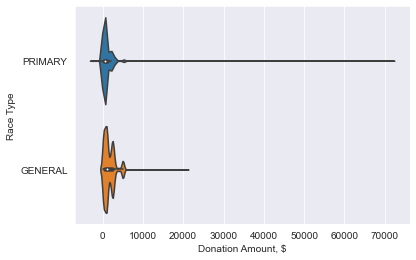

In [9]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'fec_election_type_desc', data = df[df.recipient_committee_type == 'S'])
plt.xlabel('Donation Amount, $')
plt.ylabel('Race Type')
plt.show()

Now zooming in a bit:

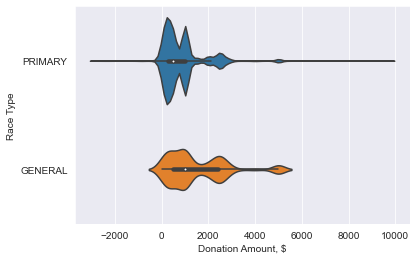

In [10]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'fec_election_type_desc',
               data = df[(df.recipient_committee_type == 'S') & (df.contribution_receipt_amount < 10000)])
plt.xlabel('Donation Amount, $')
plt.ylabel('Race Type')
plt.show()

Looks like there are negative contributions?

In [11]:
print((df.contribution_receipt_amount < 0).sum())
df[df.contribution_receipt_amount < 0].head()

83


,committee_id,committee_name,report_year,report_type,image_number,line_number,transaction_id,file_number,committee_name.1,entity_type,entity_type_desc,unused_contbr_id,contributor_prefix,contributor_name,recipient_committee_type,recipient_committee_org_type,recipient_committee_designation,contributor_first_name,contributor_middle_name,contributor_last_name,contributor_suffix,contributor_street_1,contributor_street_2,contributor_city,contributor_state,contributor_zip,contributor_employer,contributor_occupation,contributor_id,receipt_type,receipt_type_desc,receipt_type_full,memo_code,memo_code_full,contribution_receipt_date,contribution_receipt_amount,contributor_aggregate_ytd,candidate_id,candidate_name,candidate_first_name,candidate_last_name,candidate_middle_name,candidate_prefix,candidate_suffix,candidate_office,candidate_office_full,candidate_office_state,candidate_office_state_full,candidate_office_district,conduit_committee_id,conduit_committee_name,conduit_committee_street1,conduit_committee_street2,conduit_committee_city,conduit_committee_state,conduit_committee_zip,donor_committee_name,national_committee_nonfederal_account,election_type,election_type_full,fec_election_type_desc,fec_election_year,amendment_indicator,amendment_indicator_desc,schedule_type_full,load_date,original_sub_id,back_reference_transaction_id,back_reference_schedule_name,filing_form,link_id,is_individual,memo_text,two_year_transaction_period,schedule_type,increased_limit,sub_id,pdf_url,line_number_label
915,C00238907,REED COMMITTEE,1994,Q3,94015442853,NaN,NaN,NaN,REED COMMITTEE,NaN,NaN,NaN,NaN,"REDIHAN, CHARLES N JR",H,NaN,P,CHARLES N JR,NaN,REDIHAN,NaN,NaN,NaN,CUMBERLAND,RI,02864,KIERNAN PLUNKETT & REDIHAN,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1994-09-06 00:00:00,-175.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 18:41:11.522147,NaN,NaN,NaN,F3,3032920021022122377,t,NaN,1994,SA,NaN,3061920110003818376,http://docquery.fec.gov/cgi-bin/fecimg/?940154...,NaN
927,C00238907,REED COMMITTEE,1994,Q3,94015442856,NaN,NaN,NaN,REED COMMITTEE,NaN,NaN,NaN,NaN,"COLLETTA, HARRY",H,NaN,P,HARRY,NaN,COLLETTA,NaN,NaN,NaN,CRANSTON,RI,02910,TOPS ELECTRIC,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1994-09-01 00:00:00,-1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 18:41:11.522147,NaN,NaN,NaN,F3,3032920021022122377,t,NaN,1994,SA,NaN,3061920110003821703,http://docquery.fec.gov/cgi-bin/fecimg/?940154...,NaN
1065,C00238907,REED COMMITTEE,1994,30G,94015611811,NaN,NaN,NaN,REED COMMITTEE,NaN,NaN,NaN,NaN,"CONWAY, MICHAEL J",H,NaN,P,MICHAEL J,NaN,CONWAY,NaN,NaN,NaN,UPER MONTCLAIR,NJ,07043,LEHMAN BROS,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1994-11-28 00:00:00,-500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NO CHANGE,ITEMIZED RECEIPTS,2017-06-07 18:41:11.522147,NaN,NaN,NaN,F3,3032920021022123157,t,NaN,1994,SA,NaN,3061920110004019568,http://docquery.fec.gov/cgi-bin/fecimg/?940156...,NaN
1480,C00238907,REED COMMITTEE,1995,YE,96020061147,NaN,NaN,NaN,REED COMMITTEE,NaN,NaN,NaN,NaN,"SCHICK, DAVID",S,NaN,P,DAVID,NaN,SCHICK,NaN,NaN,NaN,NEW YORK,NY,10016,SCHICK & SIMON LLP,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1995-12-14 00:00:00,-1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,ADD,ITEMIZED RECEIPTS,2017-06-07 18:53:06.345564,NaN,NaN,NaN,F3,3040120021023046400,t,NaN,1996,SA,NaN,3061920110004492984,http://docquery.fec.gov/cgi-bin/fecimg/?960200...,NaN
1647,C00238907,REED COMMITTEE,1996,30G,96020303335,NaN,NaN,NaN,REED COMMITTEE,NaN,NaN,NaN,NaN,"ZARELLA, GERALD",S,NaN,P,GERALD,NaN,ZARELLA,NaN,NaN,NaN,WARWICK,RI,02886,ZARRELLA CATAURO,NaN,NaN,15,CONTRIBUTION,CONTRIBUTION,NaN,NaN,1996-11-25 00:00:00,-1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

It's not clear what these indicate, but they are very few, so we'll drop them in the cleaning section. Let's once again look at the distribution of contributions, this time eliminating negatives and zooming some more.

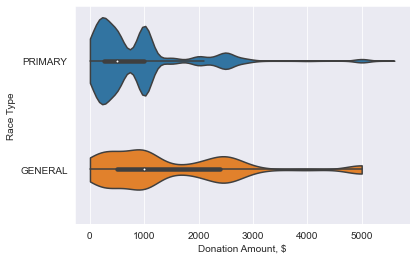

In [12]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'fec_election_type_desc', cut = 0,
               data = df[(df.recipient_committee_type == 'S') & (df.contribution_receipt_amount.between(0, 6000))])
plt.xlabel('Donation Amount, $')
plt.ylabel('Race Type')
plt.show()

General election donations basically come in a uniform variety of sizes up to ~\\$1,200, and then clump around \\$2,500—just under an individual's legal limit for each election. Primary donations seem to be heavily clumped around \\$200-300, \\$1000, and to a lesser extent \\$2,500 also. Let's zoom in one last time on the portion below \\$3000. We can see these trends more clearly this way.

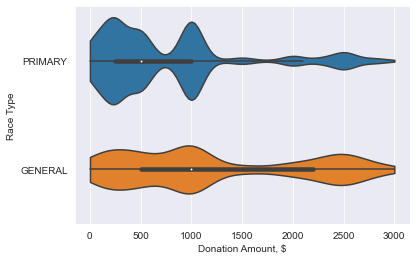

In [13]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'fec_election_type_desc', cut = 0,
               data = df[(df.recipient_committee_type == 'S') & (df.contribution_receipt_amount.between(0, 3000))])
plt.xlabel('Donation Amount, $')
plt.ylabel('Race Type')
plt.show()

Now let's compare individual donations to non-individual donations. First, what's the overall breakdown of donation amounts between individuals and non-individuals?

In [14]:
totals_by_type = df.groupby(df.is_individual).contribution_receipt_amount.agg('sum')
print(totals_by_type)

is_individual
f     7741454.51
t    10045416.37
Name: contribution_receipt_amount, dtype: float64


\\$10 million from individuals, \\$7.7 million from non-individuals.

What do the overall distributions for individuals and non-individuals look like?

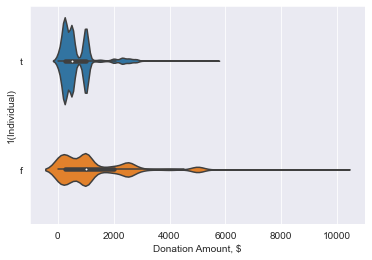

In [15]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'is_individual', #cut = 0,
               data = df[(df.recipient_committee_type == 'S') & (df.contribution_receipt_amount.between(0, 10000))])
plt.xlabel('Donation Amount, $')
plt.ylabel('1(Individual)')
plt.show()

Zooming in again:

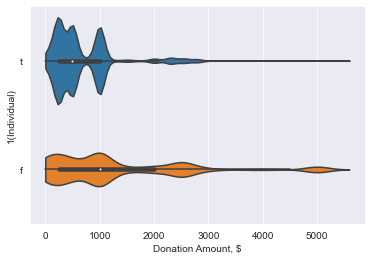

In [16]:
sns.violinplot(x = 'contribution_receipt_amount', y = 'is_individual', cut = 0,
               data = df[(df.recipient_committee_type == 'S') & (df.contribution_receipt_amount.between(0, 6000))])
plt.xlabel('Donation Amount, $')
plt.ylabel('1(Individual)')
plt.show()

As one might expect, the distribution for non-individuals is much more skewed to the right.

Let's look at the breakdown *within* non-individuals. For a subset of observations, the data contain information on what type of entity made the donation. Specifically, the type of entity making the donation is categorized as one of:

In [17]:
print('Entity types:', df.entity_type_desc.unique())

Entity types: [nan 'INDIVIDUAL' 'POLITICAL ACTION COMMITTEE' 'ORGANIZATION'
 'OTHER COMMITTEE' 'CAMPAIGN COMMITTEE']


We know the entity type for about a third of non-individual donations:

In [18]:
print('Donations by non-individuals:', (df.is_individual == 'f').sum())
print('Donations by non-individuals, entity type is known:', df[df.is_individual == 'f'].entity_type_desc.notnull().sum())

Donations by non-individuals: 5889
Donations by non-individuals, entity type is known: 2208


PACs make the overwhelming bulk of non-individual donations by raw number...

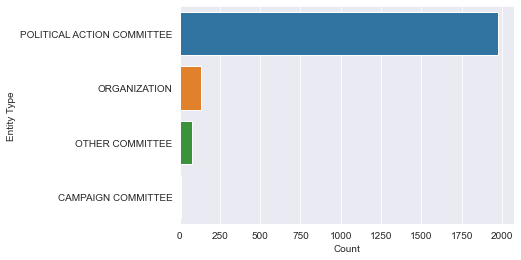

In [19]:
sns.countplot(y = 'entity_type_desc', data = df[df.entity_type_desc != 'INDIVIDUAL'])
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.show()

as well as by dollar value:

In [20]:
totals_by_type = df[df.entity_type_desc != 'INDIVIDUAL'].groupby(df.entity_type_desc).contribution_receipt_amount.agg('sum')
print(totals_by_type)

entity_type_desc
CAMPAIGN COMMITTEE               9750.00
ORGANIZATION                    27209.46
OTHER COMMITTEE                153331.05
POLITICAL ACTION COMMITTEE    2507638.00
Name: contribution_receipt_amount, dtype: float64


\\$2.5 million from PACs dwarfs the next greatest, \\$0.15 million from "other committees".

Note that this difference is somewhat inflated, though, because about a third of this \\$2.5 million actually comes from ActBlue, which is just a conduit for individual donors:

In [21]:
df[(df.entity_type_desc == 'POLITICAL ACTION COMMITTEE') & (df.contributor_name == 'ACTBLUE')].contribution_receipt_amount.sum()

860151.0

Now let's look at how donations have varied over time.

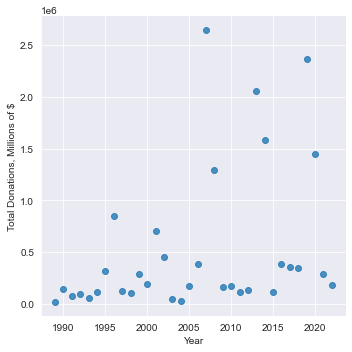

In [22]:
# Convert receipt date to year
df2 = df.copy()
df2['year'] = df2.contribution_receipt_date.str[:4].dropna().astype(int)

# Aggregate to year level and plot
total_by_year = df2.groupby(df2.year).sum().reset_index()
sns.lmplot(x = 'year', y = 'contribution_receipt_amount', data = total_by_year, fit_reg = False)
plt.xlabel('Year')
plt.ylabel('Total Donations, Millions of $')
plt.show()

As expected, the bulk of donations are made in the years of, or just before, his Senate elections.

Now let's aggregate to the donor level and look at total contributions by donor.

A caveat about this: Recall that many contributor IDs are missing. Because of this, total contributions are likely to be understated across the board. That said, there is no reason to think this distorts the observed _distribution_ of donations—that is, the _relative_ contributions across donors. We can still glean some interesting trends.

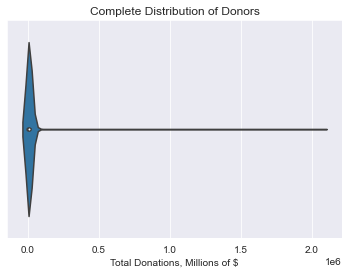

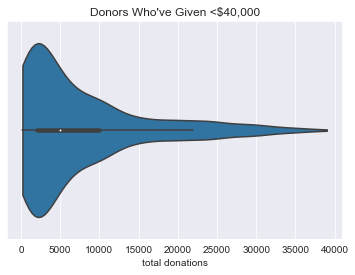

In [23]:
total_by_id = df[df.contributor_id.notnull()]
total_by_id = total_by_id.groupby(total_by_id.contributor_id).contribution_receipt_amount.sum().reset_index()

# Full distribution
sns.violinplot(x = total_by_id.contribution_receipt_amount)
plt.xlabel('Total Donations, Millions of $')
plt.title('Complete Distribution of Donors')
plt.show()

# Zoomed in
sns.violinplot(x = total_by_id[total_by_id.contribution_receipt_amount.between(0, 40000)].contribution_receipt_amount, cut = 0)
plt.xlabel('total donations')
plt.title('Donors Who\'ve Given <$40,000')
plt.show()

As one would expect, the distribution of donor sizes is very skewed to the right.

Let's see who the top donors actually are.

In [24]:
# Merge totals back with names and organization types
string_data = df[(df.contributor_id.notnull()) & (df.contributor_name.notnull())]
string_data = string_data[['contributor_id', 'contributor_name', 'entity_type_desc', 'is_individual']]
string_data = string_data.groupby(string_data.contributor_id).last().reset_index()
total_by_id = string_data.merge(total_by_id, on = 'contributor_id')

# Top donors overall
total_by_id[['contributor_name', 'contribution_receipt_amount']].sort_values('contribution_receipt_amount', ascending = False).head(10)

,contributor_name,contribution_receipt_amount
541,ACTBLUE,2067550.77
316,NORPAC,81500.00
753,SENATE IMPACT 2020,77664.48
141,EMPLOYEES OF RAYTHEON TECHNOLOGIES CORPORATION...,39000.00
65,AMERICAN ASSOCIATION FOR JUSTICE POLITICAL ACT...,37500.00
752,BLUE SENATE 2020,36128.74
36,LABORERS' INTERNATIONAL UNION OF NORTH AMERICA...,35000.00
91,AIR LINE PILOTS ASSOCIATION PAC,35000.00
436,PRAIRIE POLITICAL ACTION COMMITTEE,35000.00
189,TEXTRON INC. POLITICAL ACTION COMMITTEE,34000.00


Once again ignoring ActBlue, the largest donors by a large margin are NORPAC, an Israel-lobby organization; and Senate Impact 2020, a PAC founded by top Hollywood executives to fundraise for a few Democratic senators seeking reelection in 2020. Each of these raised double the amount of the next donor down, Raytheon's PAC. After that, we have:

-the American Association for Justice, a lobbying firm focused on fighting tort reform and pre-trial arbitration, which WaPo has described as "one of the Democratic Party's most influential political allies"

-Blue Senate 2020, another 2020 Democratic Senate race-fundraising organization, funded largely by law firms

-the Laborers' Union, a largely construction-worker union

-the Air Line Pilots' Association, a pilots' union

-Prairie PAC, a PAC that mainly funds Democrats in the midwest (especially Illinois), and is led by Dick Durbin

-Textron, an industrial conglomerate headquartered in Rhode Island

## Data Cleaning

In [25]:
# Read in data anew
df = pd.read_csv('raw_receipts.csv', low_memory = False)

# Drop obs with negative or missing contributions
df = df[(df.contribution_receipt_amount.notnull()) & (df.contribution_receipt_amount >= 0)]

# Drop obs where some other candidate is a recipient — unclear why the FEC puts these here
df = df[~(df.candidate_last_name.isin(['CICILLINE', 'MORAN', 'MCKEON', 'DODD', 'KING']))]

# Convert contribution_receipt_date to int year
df['year'] = df.contribution_receipt_date.str[:4].dropna().astype(int)

Note that the entity_type flag can be improved via the is_individual flag:

In [26]:
pd.crosstab(df.is_individual.fillna(' NaN'), df.entity_type_desc.fillna(' NaN'), dropna = False)

entity_type_desc,NaN,INDIVIDUAL,ORGANIZATION,OTHER COMMITTEE,POLITICAL ACTION COMMITTEE
is_individual,,,,,
f,3678,16,131,75,1976
t,6647,8948,0,1,0


so let's make that fix:

In [27]:
df.entity_type_desc.mask((df.is_individual == 't') & (df.entity_type_desc.isnull()), 'INDIVIDUAL', inplace = True)
pd.crosstab(df.is_individual.fillna(' NaN'), df.entity_type_desc.fillna(' NaN'), dropna = False)

entity_type_desc,NaN,INDIVIDUAL,ORGANIZATION,OTHER COMMITTEE,POLITICAL ACTION COMMITTEE
is_individual,,,,,
f,3678,16,131,75,1976
t,0,15595,0,1,0


In [28]:
# Replace empty cells and miscodings with nans
df.replace('', np.nan, inplace = True)
df.contributor_occupation.replace(['CONDUIT TOTAL LISTED IN AGG. FIELD', 'CONDUIT TOTAL LISTED IN AGG.FIELD',
                                   'INFORMATION REQUESTED'], np.nan, inplace = True)

# Consolidate same (or very similar) occupations — based on inspection of those most commonly listed
df.contributor_occupation.replace(['PRESIDENT', 'EXECUTIVE', 'CEO', 'VICE PRESIDENT', 'PRESIDENT AND CEO', 'CHAIRMAN',
                                   'MANAGING DIRECTOR', 'EXEC. VICE PRESIDENT', 'COO', 'FOUNDER & CEO', 'PRESIDENT & CEO',
                                   'EXECUTIVE DIRECTOR', 'SR. VICE PRESIDENT', 'VICE CHAIRMAN', 'PRESIDENT AND C.E.O.',
                                   'VICE PRESIDENT, DEFENSE DIVISION', 'CHAIRMAN AND CEO', 'EXECUTIVE VICE PRESIDENT',
                                   'CHAIRMAN OF THE BOARD', 'CFO', 'CHAIRMAN & CEO', 'FOUNDER', 'PRESIDENT/CEO',
                                   'SENIOR VICE PRESIDENT', 'DIRECTOR', 'VP', 'SR. VP', 'SENIOR VP'],
                                  'EXEC', inplace = True)
df.contributor_occupation.replace('NONE', 'NOT EMPLOYED', inplace = True)
df.contributor_occupation.replace(['OWNER', 'PRESIDENT/OWNER'], 'BUSINESS OWNER', inplace = True)
df.contributor_occupation.replace(['ATTORNEY AT LAW', 'LAWYER', 'ATTORNEY/PARTNER', 'MANAGING PARTNER', 'GENERAL COUNSEL',
                                   'ATTORNEY-AT-LAW'],
                                  'ATTORNEY', inplace = True)
df.contributor_occupation.replace('REAL ESTATE DEVELOPMENT', 'REAL ESTATE DEVELOPER', inplace = True)
df.contributor_occupation.replace('ENGINEERING', 'ENGINEER', inplace = True)
df.contributor_occupation.replace('CPA', 'ACCOUNTANT', inplace = True)

# Label all occupations past the 25 most common as "other"
most_common_occs = df.contributor_occupation.value_counts()[:25].index.tolist()
df.contributor_occupation.where(df.contributor_occupation.isin(most_common_occs), 'OTHER', inplace = True)

In [29]:
# Subset to important variables
donations_df = df[['contributor_name', 'recipient_committee_type', 'contributor_id', 'contributor_state', 'contributor_occupation',
               'year', 'contribution_receipt_amount', 'fec_election_type_desc', 'entity_type_desc']].copy()

# Rename variables
donations_df.rename(columns = {'contribution_receipt_amount' : 'amount',
                           'contributor_name' : 'donor',
                           'recipient_committee_type' : 'chamber',
                           'contributor_id' : 'donor_id',
                           'contributor_state' : 'donor_state',
                           'contributor_occupation' : 'donor_occ',
                           'fec_election_type_desc' : 'race_type',
                           'entity_type_desc' : 'entity_type'},
                inplace = True)

# Output donation-level csv
donations_df.to_csv('cleaned_donation_level_data.csv', index = False)

In [30]:
### Aggregate to donor level

# DF of total donations
totals_df = donations_df[donations_df.donor_id.notnull()]
totals_df = totals_df[['donor_id', 'amount']].groupby(totals_df.donor_id).sum().reset_index()

# DF of donor info
donors_df = donations_df[donations_df.donor_id.notnull()]
donors_df = donors_df[['donor', 'donor_id', 'donor_state', 'donor_occ', 'entity_type']]
donors_df = donors_df.groupby(donors_df.donor_id).agg(lambda x: x.mode().get(0, np.nan)).reset_index()





What that last line is supposed to do is collapse to the donor level, taking the modal non-missing value for their occupation, state of residence, and other info. However, for some reason, this doesn't work for occupations—you end up with everyone categorized as "other" (see below). For the life of me, I cannot track down why this is happening, but I can't use the occupation variable because of this.

In [31]:
# I give up
print(donors_df.donor_occ.unique())
donors_df.drop('donor_occ', axis = 1, inplace = True)

['OTHER']


In [32]:
# Merge DFs
donors_df = donors_df.merge(totals_df, on = 'donor_id')

# Output donor-level csv
donors_df.to_csv('cleaned_donor_level_data.csv', index = False)

## Feature Engineering

There unfortunately aren't many potential input features in this dataset. We'll just convert the categorical features into dummy variables.

In [33]:
# Read in saved donor dataset
donors_df = pd.read_csv('cleaned_donor_level_data.csv')
donors_df.head()

,donor_id,donor,donor_state,entity_type,amount
0,C00000422,AMERICAN MEDICAL ASSOCIATION PAC AMPAC,DC,POLITICAL ACTION COMMITTEE,9000.0
1,C00000729,AMERICAN DENTAL PAC,DC,NaN,17500.0
2,C00000885,INTERNATIONAL UNION OF PAINTERS & ALLIED TRADES,MD,POLITICAL ACTION COMMITTEE,19750.0
3,C00000901,BUILD PAC,DC,POLITICAL ACTION COMMITTEE,20500.0
4,C00001016,CARPENTERS LEGISLATIVE IMP CMTE- UNITED BROTHERHO,DC,NaN,11500.0


In [34]:
# Convert state, entity type, and occupation into dummies
donors_df = pd.get_dummies(donors_df, columns = ['donor_state', 'entity_type'], dummy_na = True)

# Final, full set of attributes
abt = donors_df.drop(['donor_id', 'donor'], axis = 1)
abt.head()

,amount,donor_state_AK,donor_state_AL,donor_state_AR,donor_state_AZ,donor_state_CA,donor_state_CO,donor_state_CT,donor_state_DC,donor_state_DE,donor_state_FL,donor_state_GA,donor_state_HI,donor_state_IA,donor_state_IL,donor_state_IN,donor_state_KS,donor_state_LA,donor_state_MA,donor_state_MD,donor_state_MI,donor_state_MN,donor_state_MO,donor_state_MT,donor_state_NC,donor_state_ND,donor_state_NE,donor_state_NH,donor_state_NJ,donor_state_NM,donor_state_NV,donor_state_NY,donor_state_OH,donor_state_OK,donor_state_OR,donor_state_PA,donor_state_RI,donor_state_SC,donor_state_TN,donor_state_TX,donor_state_VA,donor_state_VT,donor_state_WA,donor_state_WI,donor_state_WV,donor_state_nan,entity_type_INDIVIDUAL,entity_type_OTHER COMMITTEE,entity_type_POLITICAL ACTION COMMITTEE,entity_type_nan
0,9000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,17500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,19750.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,20500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,11500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Model Training

I will train and select the optimal model as follows. First, I will split the data into a training set and test set. I will train five classes of models on the training data, each on a grid of hyperparameters. For each model class, I will choose the optimal hyperparameters by (10-fold) cross validation on the training data. I will then see how the optimal model for each class performs on the test data, and use standard accuracy metrics to determine which is best.

The five model classes I will try are LASSO, ridge regression, elastic net, random forest, and gradient boosting.

In [35]:
# Create separate object for target variable
y = abt.amount

# Create separate object for input features
X = abt.drop('amount', axis=1)

# Split sample into test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

616 155 616 155


In [36]:
# Pipelines
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state = seed)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state = seed)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state = seed)),
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state = seed)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state = seed))
}

In [37]:
# Hyperparameter grids

# LASSO
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100] 
}

# Ridge
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100]  
}

# Elastic net
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100],                        
    'elasticnet__l1_ratio' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random forest
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [50, 100, 150, 200, 250, 300],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestregressor__max_depth' : [1, 3, 5, 7, 9]
}

# Gradient boosting
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [50, 100, 200],
    'gradientboostingregressor__learning_rate' : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth' : [1, 3, 5, 7, 9]
}

# Gather grids
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet'  : enet_hyperparameters,
    'rf'    : rf_hyperparameters,
    'gb'    : gb_hyperparameters
}

In [38]:
# Fit models

# Initialize models dictionary
fitted_models = {}

# Loop over model pipelines, tuning each model and storing the output
for method, pipeline in pipelines.items():
    
    # Initialize model/grid search object
    model = GridSearchCV(pipeline, hyperparameters[method], cv = 10, n_jobs = -1)
    
    # Train model on training data for all hyperparameters
    model.fit(X_train, y_train)
    
    # Store output
    fitted_models[method] = model
    
    print(method, 'has been fitted.')

# Confirm for sure that models were fitted correctly
for method, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print('Confirmed:', method, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
Confirmed: lasso has been fitted.
Confirmed: ridge has been fitted.
Confirmed: enet has been fitted.
Confirmed: rf has been fitted.
Confirmed: gb has been fitted.


## Model Selection

Before moving to the test data, let's look at the models' performances on the training data. Below I report the mean cross-validated R-squareds for each model with its optimal hyperparameters. We can already see that the regression methods all perform poorly, and only the tree-based methods are in contention:

In [39]:
for method, model in fitted_models.items():
    print(method, '\n',
          '--------', '\n',
          'best score: ', model.best_score_, '\n',
          'best params: ', model.best_params_, '\n\n',
          sep = '')

lasso
--------
best score: -17.97005808762335
best params: {'lasso__alpha': 100}


ridge
--------
best score: -12.690342794132535
best params: {'ridge__alpha': 100}


enet
--------
best score: -0.3394697910040279
best params: {'elasticnet__alpha': 50, 'elasticnet__l1_ratio': 0.1}


rf
--------
best score: 0.05094521508253989
best params: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 300}


gb
--------
best score: 0.04511255879903062
best params: {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 50}




Now let's see the models' performances on the test data:

In [40]:
for method, model in fitted_models.items():
    pred = model.predict(X_test)
    print(method, '\n',
          '--------', '\n',
          'R^2: ', r2_score(y_test, pred), '\n',
          'MSE: ', mean_squared_error(y_test, pred), '\n',
          'MAE: ', mean_absolute_error(y_test, pred), '\n\n',
         sep = '')

lasso
--------
R^2: -3.054816959130057
MSE: 535694023.5081482
MAE: 10148.359512502246


ridge
--------
R^2: -1.9070090387722303
MSE: 384053678.3905913
MAE: 9227.533175063232


enet
--------
R^2: -0.013686024368942507
MSE: 133921099.38414614
MAE: 8564.784997190776


rf
--------
R^2: 0.11742042688630805
MSE: 116600233.0938295
MAE: 6475.1797724172775


gb
--------
R^2: 0.1269272833884778
MSE: 115344253.78282884
MAE: 6570.162876042282




Once again, only the tree-based methods are in the running, with gradient boosting narrowly winning on R-squared and mean squared error, but random forest winning on mean absolute error.

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.05,
                                           loss='squared_error', max_depth=3,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=50,
                                           n_iter_no_change=None,
         

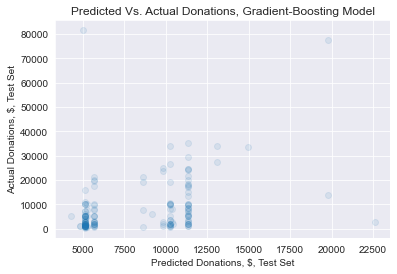

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error', max_depth=3,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=9202022,
                                       verbose=0, warm_start=False))],
         verbose=False)


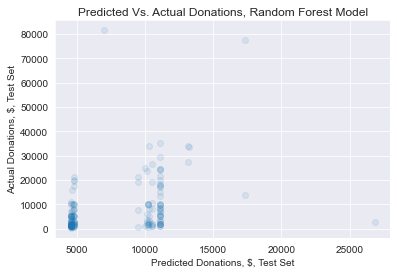

In [41]:
print(fitted_models['gb'].best_estimator_)
plt.scatter(fitted_models['gb'].predict(X_test), y_test, alpha = 0.1)
plt.xlabel('Predicted Donations, $, Test Set')
plt.ylabel('Actual Donations, $, Test Set')
plt.title('Predicted Vs. Actual Donations, Gradient-Boosting Model')
plt.show()

print(fitted_models['rf'].best_estimator_)
plt.scatter(fitted_models['rf'].predict(X_test), y_test, alpha = 0.1)
plt.xlabel('Predicted Donations, $, Test Set')
plt.ylabel('Actual Donations, $, Test Set')
plt.title('Predicted Vs. Actual Donations, Random Forest Model')
plt.show()

In [42]:
# Save tree-based models
with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

## Takeaways

This is a good example of a dataset from which more can be gleaned with simple statistics and graphs than with more complex methods. Notice that although the tree-based methods performed better than the regression-based methods, the former _still_ only had R-squareds of ~12% on the test data. On the other hand, examining the distributions of donations and donors graphically, and inspecting the top donors' occupations and organizations, provided a useful (if heuristic) sense of where and whom this senator's funding comes from.